# Orientación de calles en cada polígono

¿Qué efecto tiene la topología del terreno en el sistema?
Para elegir un buen contraste, con este código se generan visualizaciones de las orientaciones de las calles en los polígonos bajo estudio.

Está basado en [este artículo](https://geoffboeing.com/2018/07/city-street-orientations-world/).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import osmnx as ox
import pandas as pd

ox.config(log_console=True, use_cache=True)
weight_by_length = True

In [2]:
places = {
 'cdneza': {
     "ne_lng": -99.00699800141308,
     "sw_lat": 19.384415699736078,
     "sw_lng": -99.05460199858692,
     "ne_lat": 19.42958420026392},
 'xochimilco_centro': {
     "ne_lng": -99.08337660141179,
     "sw_lat": 19.232770999736076,
     "sw_lng": -99.13093679858822,
     "ne_lat": 19.277940200263927},
 'CU': {
     "ne_lng": -99.16251090141232, 
     "sw_lat": 19.295115499736074, 
     "sw_lng": -99.21008909858769, 
     "ne_lat": 19.340284400263922},
 'UACM': {
     "ne_lng": -99.14792280141279,
     "sw_lat": 19.35164569973608,
     "sw_lng": -99.1955171985872,
     "ne_lat": 19.396814300263923}
}


## Obtener redes de calles con sus orientaciones

In [3]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [4]:
bearings = {}
graphs = {}
for place in sorted(places.keys()):
    
    # get the graph
    bbox = places[place]
    G = ox.graph_from_bbox(bbox['ne_lat'], bbox['sw_lat'],
                       bbox['ne_lng'], bbox['sw_lng'],
                       network_type='bike',
                       simplify=True,
                       clean_periphery=True)
    graphs[place] = G.copy()
    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

## Visualización

In [5]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [6]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=9, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / float(count.sum())
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='indigo', edgecolor='k', linewidth=0.5, alpha=0.5)

    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'FreeSans', 'size':14, 'weight':'bold'}
    xtick_font = {'family':'FreeSans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'FreeSans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

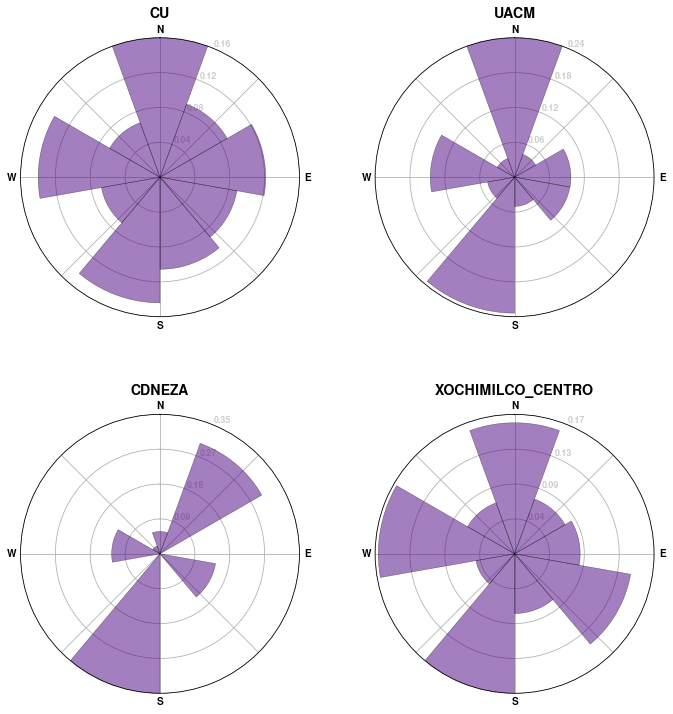

In [7]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
plt.show()

In [12]:
fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection':'polar'})
polar_plot(ax, bearings['CU'].dropna(), title='CU')

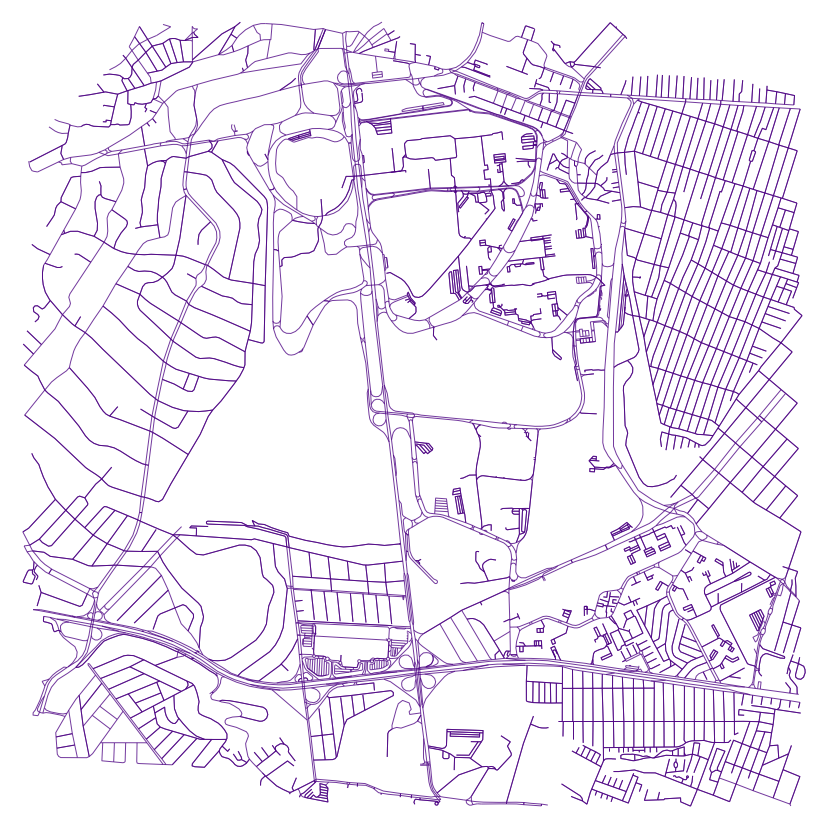

In [13]:
fig, ax = ox.plot_graph(graphs['CU'],
                        node_size=0,
                        edge_alpha=0.77,
                        edge_color='indigo',
                        dpi=100,
                        fig_height=15)


In [14]:
fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection':'polar'})
polar_plot(ax, bearings['UACM'].dropna(), title='UACM')

In [15]:
fig, ax = ox.plot_graph(graphs['UACM'],
                        node_size=0,
                        edge_alpha=0.77,
                        edge_color='indigo',
                        dpi=100,
                        fig_height=15)


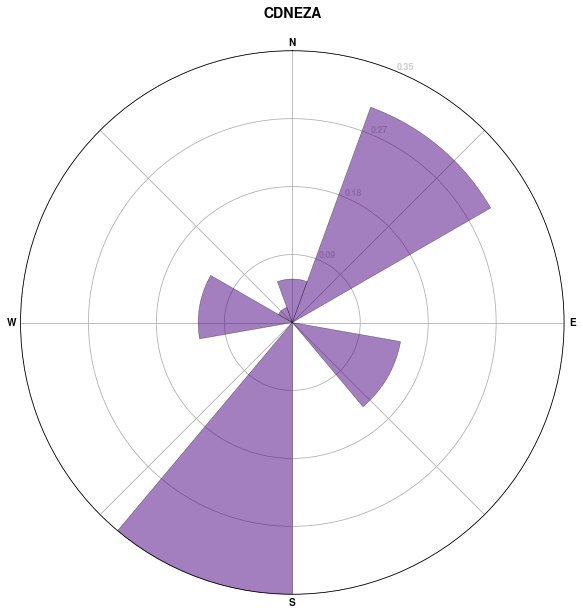

In [16]:
fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection':'polar'})
polar_plot(ax, bearings['cdneza'].dropna(), title='cdneza')

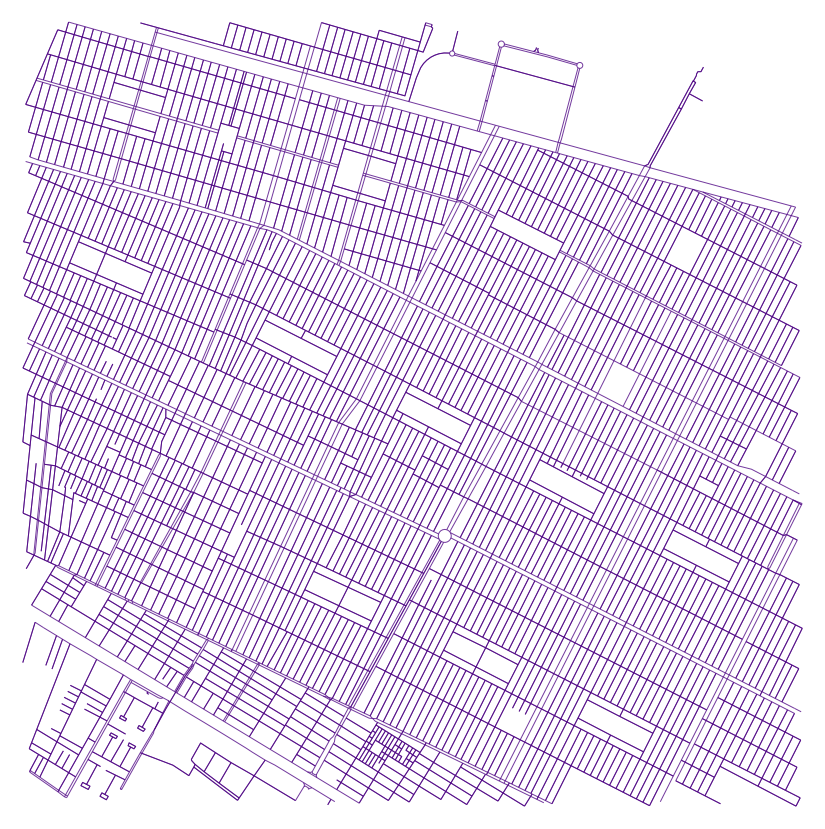

In [17]:
fig, ax = ox.plot_graph(graphs['cdneza'],
                        node_size=0,
                        edge_alpha=0.77,
                        edge_color='indigo',
                        dpi=100,
                        fig_height=15)


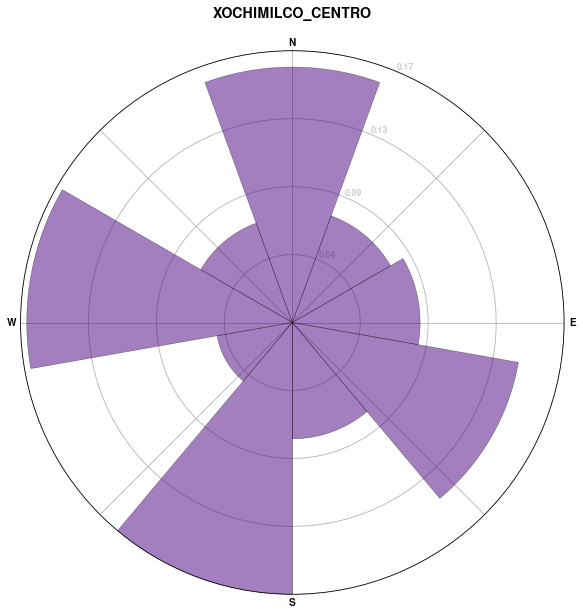

In [18]:
fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection':'polar'})
polar_plot(ax, bearings['xochimilco_centro'].dropna(), title='xochimilco_centro')

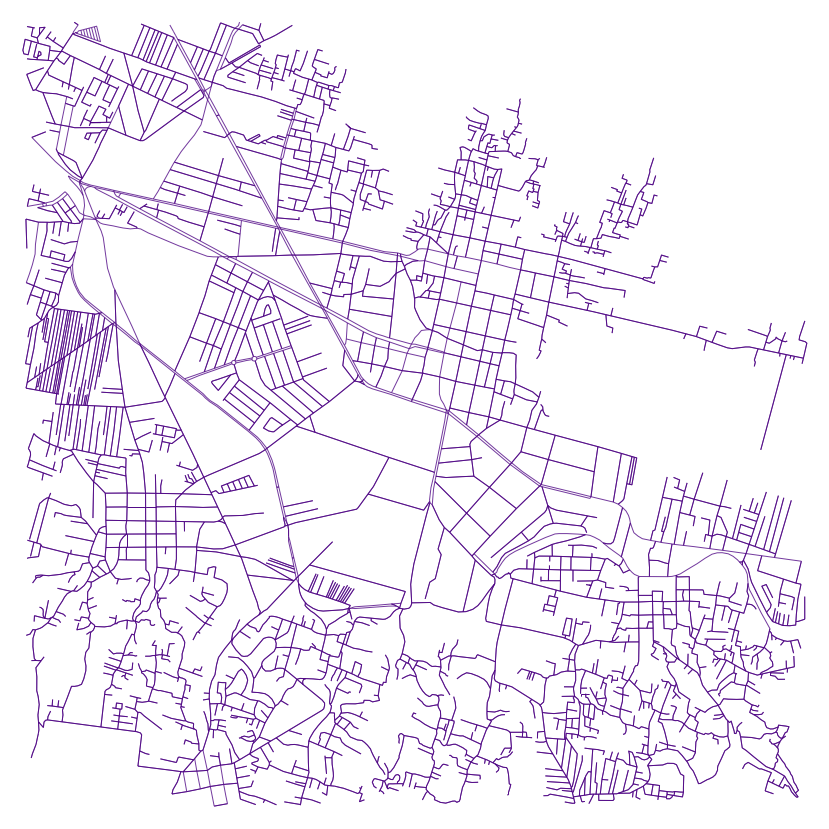

In [19]:
fig, ax = ox.plot_graph(graphs['xochimilco_centro'],
                        node_size=0,
                        edge_alpha=0.77,
                        edge_color='indigo',
                        dpi=100,
                        fig_height=15)
